In [1]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torchvision.utils as vutils

import matplotlib.pyplot as plt
import random
import numpy as np
import timeit
from tqdm import tqdm

In [ ]:
config = {
    'data_path': 'dataset/',
    'batch_size': 1024,
    'learning_rate': 2e-4,
    'channel': 1,
    'image_size': 64,
    'feature_map_size': 64, # Base number of feature maps
    'random_seed': 42,
    'device': 'cpu',
    'input_noise_dim': 100,
    'beta': 0.5,
    'num_epochs': 5,
}

In [3]:
# Set random seed for reproducibility
random.seed(config['random_seed'])
np.random.seed(config['random_seed'])
torch.manual_seed(config['random_seed'])
torch.cuda.manual_seed(config['random_seed'])
torch.cuda.manual_seed_all(config['random_seed'])
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [4]:
class Discriminator(nn.Module):
    def __init__(self, feature_map_size, channel):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(channel, feature_map_size*2, 4, 2, 1, bias=False) # size [128, 32, 32]
        self.conv2 = nn.Conv2d(feature_map_size*2, feature_map_size*4, 4, 2, 1, bias=False) # size [256, 16, 16]
        self.conv3 = nn.Conv2d(feature_map_size*4, feature_map_size*8, 4, 2, 1, bias=False) # size [512, 8, 8]
        self.conv4 = nn.Conv2d(feature_map_size*8, feature_map_size*16, 4, 2, 1, bias=False) # size [1024, 4, 4]
        self.conv5 = nn.Conv2d(feature_map_size*16, 1, 4, 1, 0, bias=False) # size [1, 1, 1]
        
        self.leaky_relu = nn.LeakyReLU(0.2, inplace=True)
        
        self.batch_norm1 = nn.BatchNorm2d(feature_map_size*4)
        self.batch_norm2 = nn.BatchNorm2d(feature_map_size*8)
        self.batch_norm3 = nn.BatchNorm2d(feature_map_size*16)
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.leaky_relu(self.conv1(x))
        x = self.leaky_relu(self.batch_norm1(self.conv2(x)))
        x = self.leaky_relu(self.batch_norm2(self.conv3(x)))
        x = self.leaky_relu(self.batch_norm3(self.conv4(x)))
        x = self.sigmoid(self.conv5(x))
        return x

In [5]:
discriminator = Discriminator(config['feature_map_size'], config['channel']).to(config['device'])
int = torch.randn(config['batch_size'], config['channel'], config['image_size'], config['image_size']).to(config['device'])
out = discriminator(int)
print(out.shape) # outpiut is a single value [batch_size, 1, 1, 1]


torch.Size([128, 1, 1, 1])


In [6]:
class Generator(nn.Module):
    def __init__(self, input_vector_dim, feature_map_dim, channels):
        super(Generator, self).__init__()
        self.convt_1 = nn.ConvTranspose2d(input_vector_dim, feature_map_dim*16, 4, 1, 0, bias=False) #size [1024, 4, 4]
        self.convt_2 = nn.ConvTranspose2d(feature_map_dim*16, feature_map_dim*8, 4, 2, 1, bias=False) #size [512, 8, 8]
        self.convt_3 = nn.ConvTranspose2d(feature_map_dim*8, feature_map_dim*4, 4, 2, 1, bias=False) #size [256, 16, 16]
        self.convt_4 = nn.ConvTranspose2d(feature_map_dim*4, feature_map_dim*2, 4, 2, 1, bias=False) #size [128, 32, 32]
        self.convt_5 = nn.ConvTranspose2d(feature_map_dim*2, channels, 4, 2, 1, bias=False) #size [3, 64, 64]
        
        self.relu = nn.ReLU()
        
        self.batch_norm_1 = nn.BatchNorm2d(feature_map_dim*16)
        self.batch_norm_2 = nn.BatchNorm2d(feature_map_dim*8)
        self.batch_norm_3 = nn.BatchNorm2d(feature_map_dim*4)
        self.batch_norm_4 = nn.BatchNorm2d(feature_map_dim*2)
        
        self.tanh = nn.Tanh()

    def forward(self, inp):
        x = self.convt_1(inp)
        x = self.batch_norm_1(x)
        x = self.relu(x)
        
        x = self.convt_2(x)
        x = self.batch_norm_2(x)
        x = self.relu(x)
        
        x = self.convt_3(x)
        x = self.batch_norm_3(x)
        x = self.relu(x)
        
        x = self.convt_4(x)
        x = self.batch_norm_4(x)
        x = self.relu(x)
        
        x = self.convt_5(x)
        out = self.tanh(x)
        
        return out

In [7]:
generator = Generator(config['input_noise_dim'], config['feature_map_size'], config['channel']).to(config['device'])
int = torch.randn(config['batch_size'], config['input_noise_dim'], 1, 1).to(config['device'])
out = generator(int)
print(out.shape) #output is image of size [batch_size, channel, 64, 64]

torch.Size([128, 1, 64, 64])


In [8]:
dataset = ImageFolder(root=config['data_path'],
                        transform=transforms.Compose([
                            transforms.Grayscale(num_output_channels=1),
                            transforms.Resize(config['image_size']),
                            transforms.CenterCrop(config['image_size']),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5,), (0.5,))
                        ]))

dataloader = DataLoader(dataset, batch_size=config['batch_size'], shuffle=True, num_workers=2)

In [9]:
criterion = nn.BCELoss()
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=config['learning_rate'], betas=(config['beta'], 0.999))
generator_optimizer = optim.Adam(generator.parameters(), lr=config['learning_rate'], betas=(config['beta'], 0.999))

100%|██████████| 24/24 [00:53<00:00,  2.23s/it]

Epoch [1/5], Discriminator Loss: 0.2047, Generator Loss: 10.9965


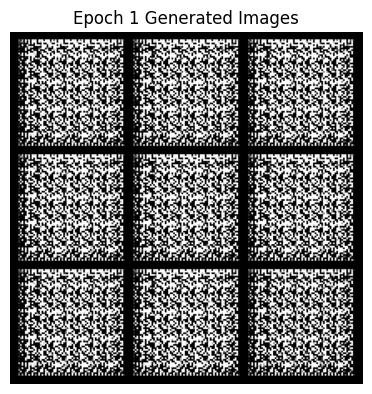

100%|██████████| 24/24 [00:57<00:00,  2.38s/it]

Epoch [2/5], Discriminator Loss: 0.0024, Generator Loss: 7.7522


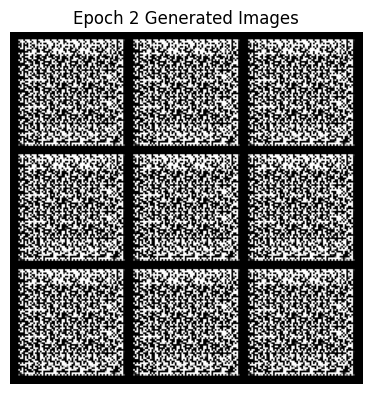

 40%|████      | 2/5 [02:17<03:25, 68.64s/it]


KeyboardInterrupt: 

In [10]:
generator.train()
discriminator.train()

for epoch in tqdm(range(config['num_epochs']), position=0, leave=True):
    generator_running_loss = 0
    discriminator_running_loss = 0
    for idx, data in enumerate( tqdm(dataloader, position=0, leave=True)):
        img = data[0].to(config['device'])
        dummy_labels = data[1]
        
        label_real_image = torch.full((dummy_labels.size()), 1, dtype=torch.float)
        label_fake_image = torch.full((dummy_labels.size()), 0, dtype=torch.float)
        noise = torch.randn(dummy_labels.size()[0], config['input_noise_dim'], 1, 1, device=config['device'])
        
        ## Train Discriminator with real images
        d_predict_real = discriminator(img).view(-1)
        d_loss_real = criterion(d_predict_real, label_real_image) # close to 1
        discriminator.zero_grad()
        d_loss_real.backward()
        
        ## Train Discriminator with fake images
        generator_fake_img = generator(noise)
        d_predict_fake = discriminator(generator_fake_img.detach()).view(-1)
        d_loss_fake = criterion(d_predict_fake, label_fake_image) # close to 0
        d_loss_fake.backward()
        
        discriminator_running_loss += d_loss_real.item() + d_loss_fake.item()
        discriminator_optimizer.step()
        
        ## Train Generator
        d_predict_fake = discriminator(generator_fake_img).view(-1) 
        g_loss = criterion(d_predict_fake, label_real_image) # try to fool the discriminator
        generator_running_loss += g_loss.item()
        generator.zero_grad()
        g_loss.backward()
        generator_optimizer.step()
    
    discriminator_loss = discriminator_running_loss / 2 / (idx + 1) # average loss per batch
    generator_loss = generator_running_loss / (idx + 1)
    
    print(f"Epoch [{epoch+1}/{config['num_epochs']}], Discriminator Loss: {discriminator_loss:.4f}, Generator Loss: {generator_loss:.4f}")

    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.axis("off")
    plt.title(f"Epoch {epoch+1} Generated Images")
    plt.imshow(np.transpose(vutils.make_grid(generator_fake_img[:9], padding=5, normalize=True, nrow=3).cpu(),(1,2,0)))
    plt.show()